In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
import nemo
import tqdm
import torch
import commons
import pathlib
import argparse
import tempfile
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

from PIL import Image
from ruamel import yaml
from nemo.collections import tts as nemo_tts

In [3]:
nemo.core.NeuralModuleFactory();

[NeMo W 2020-04-25 04:58:55 deprecated:68] Function ``_get_trainer`` is deprecated. It is going to be removed in the future version.


In [4]:
CKPT = pathlib.Path('/home/stanislavv/data/ckpts/fast-tts')
DURS_CKPT = CKPT / 'durs'
MELS_CKPT = CKPT / 'mels'
WG_CODE = pathlib.Path('../../waveglow')
WG_CKPT = pathlib.Path('/home/stanislavv/data/ckpts/waveglow.pth')

In [5]:
# Real eval sample number #0
EVAL_TEXT = 'He found them at length residing at the latter place, one as a landed proprietor, the other as a publican.\n'
EVAL_BLANKS = np.array([21,  1, 10,  3,  2,  6,  2,  0,  7,  1,  0,  0,  2,  2,  2,  2,  8,
0,  2,  4,  0,  0,  0, 11,  0,  0,  3, 11, 10,  7,  2,  0,  7,  4,
3,  6,  0,  0,  0,  5,  1,  3,  6,  4,  2,  1,  7,  3,  0,  2,  9,
0, 51,  1,  8,  6,  0, 16,  5,  2,  4,  2,  6,  3,  3,  7,  0,  8,
2,  8,  3,  0,  1, 13,  0,  2, 14,  3, 10,  2, 43,  1,  4,  0,  0,
7,  2,  9,  0,  0,  2, 12,  5,  4,  4,  2,  5,  2,  2,  4,  5,  2,
3,  9,  2, 21,  1])
EVAL_DURS = np.array([1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 3, 2, 1, 2, 1, 2,
2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1,
1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1,
2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1])

In [6]:
def load_config(dir_):
    file = next(dir_.glob('*.yaml'))
    yaml_loader = yaml.YAML(typ='safe')
    with open(file) as f:
        return argparse.Namespace(**yaml_loader.load(f))


def merge(b, d):
    result = []
    for b1, d1 in zip(b, d):
        result.extend([b1, d1])
    
    result.append(b[-1])
    return np.array(result)


def split(durs):
    return np.array(durs[::2]), np.array(durs[1::2])

In [27]:
class Tokenizer:
    def __init__(self, ckpt):
        config = load_config(ckpt)
        labels = config.labels
        pad_id, labels = len(labels), labels + ['#']
        blank_id, labels = len(labels), labels + ['~']
        self.pad_id, self.blank_id, self.labels = pad_id, blank_id, labels

        self._parser = nemo.collections.asr.parts.parsers.make_parser(
            labels=labels,
            name='en',
            unk_id=-1,
            blank_id=blank_id,
            do_normalize=config.FasterSpeechDataLayer_eval['normalize_transcripts'],
        )
    
    def __call__(self, text):
        chars = self._parser(text)
        blanks = [self.blank_id] * (len(chars) + 1)
        return merge(blanks, chars)


tok = Tokenizer(DURS_CKPT / 'xe')
assert len(tok(EVAL_TEXT)) == len(EVAL_BLANKS) + len(EVAL_DURS)

In [28]:
class DursInfer:
    def __init__(self, tok, ckpt, fp16=False):
        config = load_config(ckpt)
        self._loss = nemo_tts.FasterSpeechDursLoss(**config.FasterSpeechDursLoss)
        self._model = nemo_tts.FasterSpeech(
            n_vocab=len(tok.labels),
            pad_id=tok.pad_id,
            jasper_kwargs=config.JasperEncoder,
            d_out=self._loss.d_out,
            **config.FasterSpeech,
        )
        ckpt = nemo.utils.get_checkpoint_from_dir(['FasterSpeech'], ckpt / 'checkpoints')[0]
        self._model.restore_from(ckpt)
        self._model.eval()
        
        if fp16:
            from apex import amp
            self._model, _ = amp.initialize(self._model, [], opt_level='O3')
    
    def __call__(self, tokens):
        text = torch.tensor(tokens, device='cuda').unsqueeze_(0)
        text_mask = torch.ones_like(text)
        
        with torch.no_grad():
            start_time = time.time()
            output = self._model(text=text, text_mask=text_mask, force_pt=True)[0]
            lat = time.time() - start_time
            
        output = argparse.Namespace(dur_pred=output)
        
        durs = self._loss.preprocessing(output).dur_pred[0].tolist()
        
        # Postprocessing
        b, d = split(durs)
        (b, d), _ = commons.adjust_durs(b, d)
        durs = merge(b, d)

        return durs, lat


durs = DursInfer(tok, DURS_CKPT / 'xe')
bd, _ = durs(tok(EVAL_TEXT))
bd_gt = merge(EVAL_BLANKS, EVAL_DURS)
print('acc:', (bd == bd_gt).sum() / len(bd))
print('mse:', ((bd - bd_gt) ** 2).mean())

acc: 0.6854460093896714
mse: 5.976525821596244


In [29]:
class MelsInfer:
    def __init__(self, tok, ckpt, fp16=False):
        config = load_config(ckpt)
        self._model = nemo_tts.FasterSpeech(
            n_vocab=len(tok.labels),
            pad_id=tok.pad_id,
            jasper_kwargs=config.JasperEncoder,
            d_out=config.n_mels,
            **config.FasterSpeech,
        )
        ckpt = nemo.utils.get_checkpoint_from_dir(['FasterSpeech'], ckpt / 'checkpoints')[0]
        self._model.restore_from(ckpt)
        self._model.eval()

        if fp16:
            from apex import amp
            self._model, _ = amp.initialize(self._model, [], opt_level='O3')
    
    def __call__(self, tokens, durs):
        text = torch.tensor(tokens, device='cuda')
        text = torch.repeat_interleave(text, torch.tensor(durs, device='cuda'))
        text = text.unsqueeze_(0)
        text_mask = torch.ones_like(text)

        with torch.no_grad():
            start_time = time.time()
            output = self._model(text_rep=text, text_rep_mask=text_mask, force_pt=True)[0]
            lat = time.time() - start_time

        mel = output[0].cpu().numpy().T

        return mel, lat

In [30]:
class FastTTSInfer:
    def __init__(self, durs_ckpt, mels_ckpt, wg_code, wg_ckpt, fp16=False):
        nemo.core.NeuralModuleFactory()

        self._tok = Tokenizer(durs_ckpt)
        self._durs = DursInfer(self._tok, durs_ckpt, fp16=fp16)
        self._mels = MelsInfer(self._tok, mels_ckpt, fp16=fp16)
        self._sample_rate = load_config(mels_ckpt).sample_rate
        
        stdout, stderr = sys.stdout, sys.stderr
        with tempfile.TemporaryDirectory() as d:
            with open(os.path.join(d, 'trash'), 'w') as f:
                sys.stdout, sys.stderr = f, f
                self._vocoder = nemo_tts.WaveGlowInference(str(wg_code), wg_ckpt, fp16=fp16)
        sys.stdout, sys.stderr = stdout, stderr
        
    def __call__(self, text, denoiser=0.1):
        tokens = self._tok(text)
        durs, durs_lat = self._durs(tokens)
        mel, mel_lat = self._mels(tokens, durs)

        start_time = time.time()
        audio = self._vocoder(mel, denoiser=denoiser)
        audio_tt = time.time() - start_time
        
        chars = [self._tok.labels[t] for t in tokens]
        durs = np.array(durs)
        mel = Image.fromarray(nemo_tts.parts.helpers.plot_spectrogram_to_numpy(mel), mode='RGB')
        audio = ipd.Audio(audio, rate=self._sample_rate)
        tt = argparse.Namespace(durs=durs_lat, mel=mel_lat, audio=audio_tt)
        
        return argparse.Namespace(chars=chars, durs=durs, mel=mel, audio=audio, tt=tt)


infer = FastTTSInfer(DURS_CKPT / 'xe', MELS_CKPT, WG_CODE, WG_CKPT)

In [30]:
gen = infer(EVAL_TEXT)
gen.audio

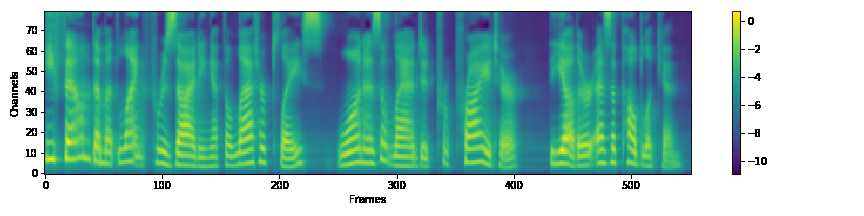

In [31]:
gen.mel

In [34]:
gen.tt

Namespace(audio=0.3262331485748291, durs=0.023157835006713867, mel=0.0419161319732666)

In [33]:
infer('Hi, Boris Ginzburg. This is a sample inferred from novel model named "Talk Net"!').audio

In [31]:
PHRASE = 'Http'
gen = infer(PHRASE)
gen.audio

In [36]:
print(*gen.chars, sep='\t')
print(*gen.durs, sep='\t')

~	h	~	t	~	t	~	p	~
3	1	0	1	5	1	10	1	2
